## Introducción

Hay un potencial de ahorro económico en la calefacción de espacios, siempre que se cumplan las premisas de que la calefacción sea eléctrica y la tarifa eléctrica tenga discriminación horaria. El método a emplear sería el encendido del sistema en las horas de menor coste y el aprovechamiento de la inercia térmica de la estancia para mantenerse dentro de la temperatura de confort.

Teniendo en cuenta que, con esta estrategia, el consumo eléctrico aumenta, el ahorro viene dado por la diferencia de precio de la electricidad entre las distintas horas, y no ésta no siempre será suficiente para compensar la mayor cantidad de energía empleada.

Dado que tanto el precio de la electricidad como la temperatura exterior prevista se conocen con una antelación suficiente, es posible hacer la predicción de gasto en calefacción para cada día con estrategias distintas, y obtener la más barata.

Este proyecto trata de generar el modelo para realizar esta predicción para una vivienda en concreto, en base a datos reales recogidos en la misma entre noviembre de 2022 y marzo de 2023. El sistema de calefacción es en base a bomba de calor, y la tarifa eléctrica es la PVPC, con discriminación horaria.

## Dataset

Los datos se extraen de una base de datos InfluxDB, mediante las consultas pertinentes, y se vuelcan a un archivo de tipo csv.

In [1]:
# Importar librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importar datos

df = pd.read_csv('../data/2023-11-18-18-52 Chronograf Data.csv')

## EDA / Feature engineering

In [3]:
df.head()

,time,kWh.mean_value,°C.mean_value,°C.mean_value_2,€/kWh.mean_value
0,2022-10-31T00:00:00.000+01:00,541.115,23.550000,16.3,0.21445
1,2022-10-31T01:00:00.000+01:00,541.135,23.800000,15.6,0.20656
2,2022-10-31T02:00:00.000+01:00,541.155,23.733333,15.0,0.17392
3,2022-10-31T03:00:00.000+01:00,541.175,23.800000,14.8,0.17453
4,2022-10-31T04:00:00.000+01:00,541.195,23.650000,15.9,0.17423


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647 entries, 0 to 3646
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              3647 non-null   object 
 1   kWh.mean_value    2862 non-null   float64
 2   °C.mean_value     3581 non-null   float64
 3   °C.mean_value_2   3382 non-null   float64
 4   €/kWh.mean_value  3636 non-null   float64
dtypes: float64(4), object(1)
memory usage: 142.6+ KB


In [5]:
# Renombrar columnas

df.rename(columns= {'kWh.mean_value': 'kWh', '°C.mean_value': 'temp_int', \
                    '°C.mean_value_2': 'temp_ext', '€/kWh.mean_value': '€/kWh'}, inplace= True)

In [6]:
# Timestamps a formato tiempo

df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M:%S.%f%z', utc= True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647 entries, 0 to 3646
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   time      3647 non-null   datetime64[ns, UTC]
 1   kWh       2862 non-null   float64            
 2   temp_int  3581 non-null   float64            
 3   temp_ext  3382 non-null   float64            
 4   €/kWh     3636 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 142.6 KB


In [8]:
# Tratamiento de NaN (del EDA)

df['€/kWh'].ffill(axis = 0, inplace= True)
df['temp_int'].ffill(axis= 0, inplace= True)
df['temp_ext'].interpolate(method='linear', limit_direction='forward', axis = 0, inplace=True)
df['kWh'].ffill(axis= 0, inplace= True)
df['kWh'].bfill(axis= 0, inplace= True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647 entries, 0 to 3646
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   time      3647 non-null   datetime64[ns, UTC]
 1   kWh       3647 non-null   float64            
 2   temp_int  3647 non-null   float64            
 3   temp_ext  3647 non-null   float64            
 4   €/kWh     3647 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 142.6 KB


In [10]:
# Generar columnas adicionales

df['consumo'] = df['kWh'].diff()
df['€/h'] = df['€/kWh'] * df['consumo']

In [11]:
# df.set_index('time', inplace= True)

In [12]:
df.head()

,time,kWh,temp_int,temp_ext,€/kWh,consumo,€/h
0,2022-10-30 23:00:00+00:00,541.115,23.550000,16.3,0.21445,NaN,NaN
1,2022-10-31 00:00:00+00:00,541.135,23.800000,15.6,0.20656,0.02,0.004131
2,2022-10-31 01:00:00+00:00,541.155,23.733333,15.0,0.17392,0.02,0.003478
3,2022-10-31 02:00:00+00:00,541.175,23.800000,14.8,0.17453,0.02,0.003491
4,2022-10-31 03:00:00+00:00,541.195,23.650000,15.9,0.17423,0.02,0.003485


In [13]:
df['dia'] = df['time'].dt.date

In [14]:
df['€/dia'] = df['€/h'].groupby(df['time'].dt.date).transform('sum')


In [15]:
# Pasar filas a columnas

for i in range(24,0,-1):
    df['t_ext-'+str(i)] = df['temp_ext'].shift(i)


In [16]:
for i in range(24,0,-1):
    df['t_int-'+str(i)] = df['temp_int'].shift(i)

In [17]:
for i in range(24,0,-1):
    df['€/kWh-'+str(i)] = df['€/kWh'].shift(i)

In [18]:
# df.reset_index(inplace= True)

In [19]:
df2 = df.copy()
# df2 = df.iloc[1::24].copy()
df3 = df.iloc[1::24].copy()

In [20]:
df2.dropna(axis= 0, how= 'any', inplace= True)
df3.dropna(axis= 0, how= 'any', inplace= True)

In [21]:
df2.drop(columns=['kWh', 'temp_int', 'temp_ext', '€/kWh', 'consumo', '€/h', 'time'], inplace= True)
df3.drop(columns=['kWh', 'temp_int', 'temp_ext', '€/kWh', 'consumo', '€/h', 'time'], inplace= True)

In [22]:
df2.set_index('dia', inplace= True)
df3.set_index('dia', inplace= True)

In [23]:
df2.head()

,€/dia,t_ext-24,t_ext-23,t_ext-22,t_ext-21,t_ext-20,t_ext-19,t_ext-18,t_ext-17,t_ext-16,...,€/kWh-10,€/kWh-9,€/kWh-8,€/kWh-7,€/kWh-6,€/kWh-5,€/kWh-4,€/kWh-3,€/kWh-2,€/kWh-1
dia,,,,,,,,,,,,,,,,,,,,,
2022-10-31,0.025415,16.3,15.6,15.0,14.8,15.9,16.5,16.9,16.3,18.2,...,0.22586,0.24425,0.24498,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566
2022-11-01,0.000000,15.6,15.0,14.8,15.9,16.5,16.9,16.3,18.2,18.4,...,0.24425,0.24498,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872
2022-11-01,0.000000,15.0,14.8,15.9,16.5,16.9,16.3,18.2,18.4,19.2,...,0.24498,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872,0.19380
2022-11-01,0.000000,14.8,15.9,16.5,16.9,16.3,18.2,18.4,19.2,19.9,...,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872,0.19380,0.16898
2022-11-01,0.000000,15.9,16.5,16.9,16.3,18.2,18.4,19.2,19.9,20.2,...,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872,0.19380,0.16898,0.16923


In [24]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3623 entries, 2022-10-31 to 2023-03-31
Data columns (total 73 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   €/dia     3623 non-null   float64
 1   t_ext-24  3623 non-null   float64
 2   t_ext-23  3623 non-null   float64
 3   t_ext-22  3623 non-null   float64
 4   t_ext-21  3623 non-null   float64
 5   t_ext-20  3623 non-null   float64
 6   t_ext-19  3623 non-null   float64
 7   t_ext-18  3623 non-null   float64
 8   t_ext-17  3623 non-null   float64
 9   t_ext-16  3623 non-null   float64
 10  t_ext-15  3623 non-null   float64
 11  t_ext-14  3623 non-null   float64
 12  t_ext-13  3623 non-null   float64
 13  t_ext-12  3623 non-null   float64
 14  t_ext-11  3623 non-null   float64
 15  t_ext-10  3623 non-null   float64
 16  t_ext-9   3623 non-null   float64
 17  t_ext-8   3623 non-null   float64
 18  t_ext-7   3623 non-null   float64
 19  t_ext-6   3623 non-null   float64
 20  t_ext-5   3623 non-n

''

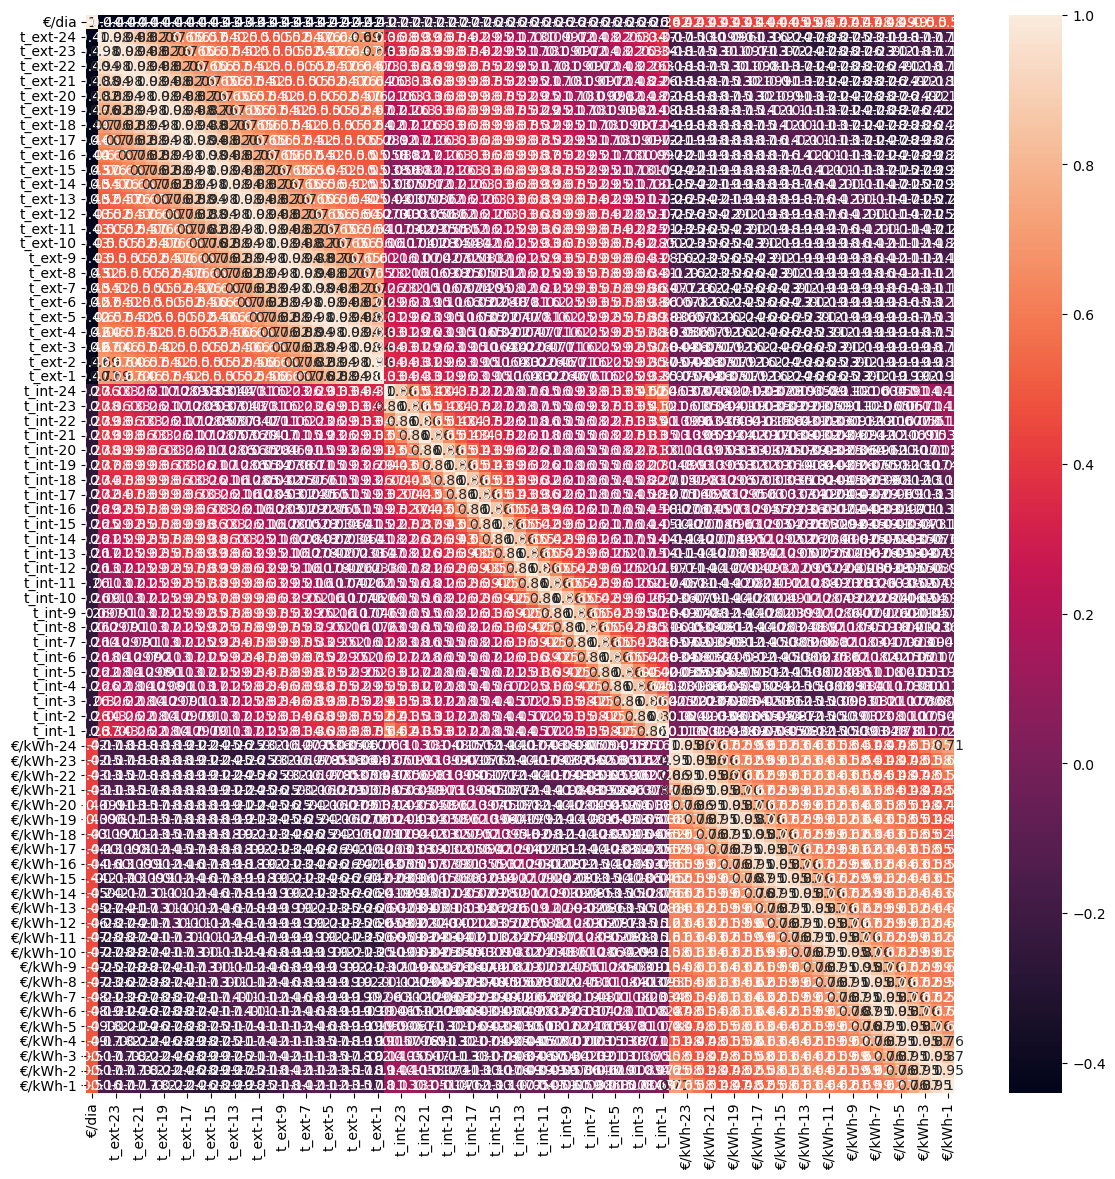

In [25]:
plt.figure(figsize= (14, 14))
sns.heatmap(df2.corr(), annot= True)
;

In [26]:
df2.reset_index(inplace= True)
df3.reset_index(inplace= True)

''

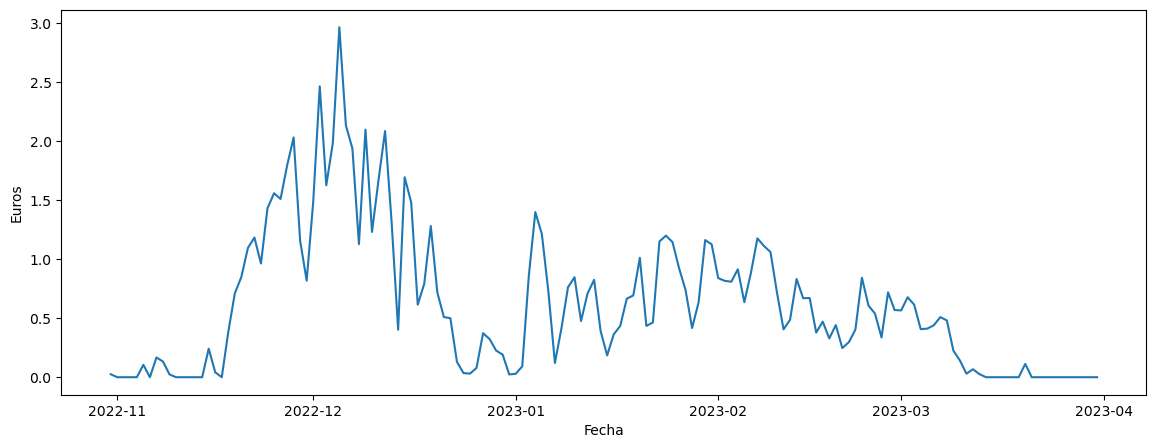

In [27]:
# Si lo trato como una serie temporal tiene este aspecto

plt.figure(figsize= (14, 5))
plt.plot(df2['dia'], df2['€/dia'])
plt.xlabel('Fecha')
plt.ylabel('Euros')
;

''

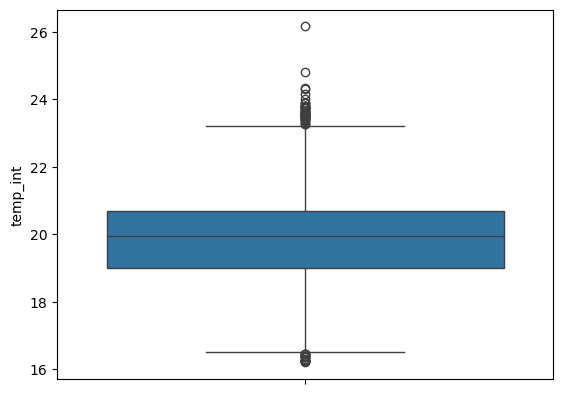

In [159]:
sns.boxplot(data= df['temp_int'])
;

In [160]:
df2.drop(columns= 'dia', inplace= True)

## Modelos

In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [163]:
X = df2.drop(columns= '€/dia')
Y = df2['€/dia']

In [164]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.20, random_state= 51)

In [165]:
X_train.shape

(2898, 72)

### Random Forest Regressor

In [166]:
# Pruebo Random Forest Regressor

r_forest = RandomForestRegressor()

#Parametros a probar en el gridsearch
parameters = {
    'n_estimators': [20, 25, 30, 35, 40, 45, 50],
    'max_depth': [1, 2]
}


#Estimador a probar en el gridsearch
# svc = svm.SVC()

#Creamos el gridsearch
clf = GridSearchCV(estimator = r_forest,
                  param_grid = parameters,
                  n_jobs = 6,
                  cv = 5,
                  scoring= 'neg_mean_absolute_error')

#Entrenamos el gridsearch
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=6,
             param_grid={'max_depth': [1, 2],
                         'n_estimators': [20, 25, 30, 35, 40, 45, 50]},
             scoring='neg_mean_absolute_error')

In [167]:
clf.best_params_

{'max_depth': 2, 'n_estimators': 45}

In [168]:
# Random Forest con parámetros optimizados

r_forest = RandomForestRegressor(n_estimators= 40, max_depth= 2)

In [169]:
r_forest.fit(X_train, Y_train)

RandomForestRegressor(max_depth=2, n_estimators=40)

In [170]:
mae_train = mean_absolute_error(Y_train, r_forest.predict(X_train))

mae_train

0.32643455615044015

In [171]:
mae_test = mean_absolute_error(Y_test, r_forest.predict(X_test))

mae_test

0.3401198275015913

In [172]:
# RMSE train

mean_squared_error(Y_train, r_forest.predict(X_train), squared= False)

0.4217399260475818

In [173]:
# RMSE test

mean_squared_error(Y_test, r_forest.predict(X_test), squared= False)

0.4353792801106466

In [174]:
mean_absolute_percentage_error(Y_train, r_forest.predict(X_train))
# En este caso MAPE no es útil, porque hay valores de y = 0. En ese caso, MAPE tiende a infinito.

309025211430024.06

### Linear Regression

In [175]:
# Pruebo una Regresión lineal

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [176]:
l_reg = LinearRegression()

In [177]:
l_reg.fit(X_train, Y_train)

LinearRegression()

In [178]:
mean_absolute_error(Y_train, l_reg.predict(X_train))

0.31565197963951536

In [179]:
mean_absolute_error(Y_test, l_reg.predict(X_test))

0.32319589032276136

### Lasso

In [181]:
baseline_error = mean_absolute_error(Y_test, l_reg.predict(X_test))

In [182]:
# Prueba Lasso

n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) 

coef_lasso = []
err_lasso = []
baseline = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter= 100000)
    lasso.fit(X_train, Y_train)
    
    coef_lasso.append(lasso.coef_)
    
    y_pred = lasso.predict(X_test)
    lasso_error = mean_absolute_error(y_pred, Y_test)
    
    err_lasso.append(lasso_error)
    baseline.append(baseline_error)

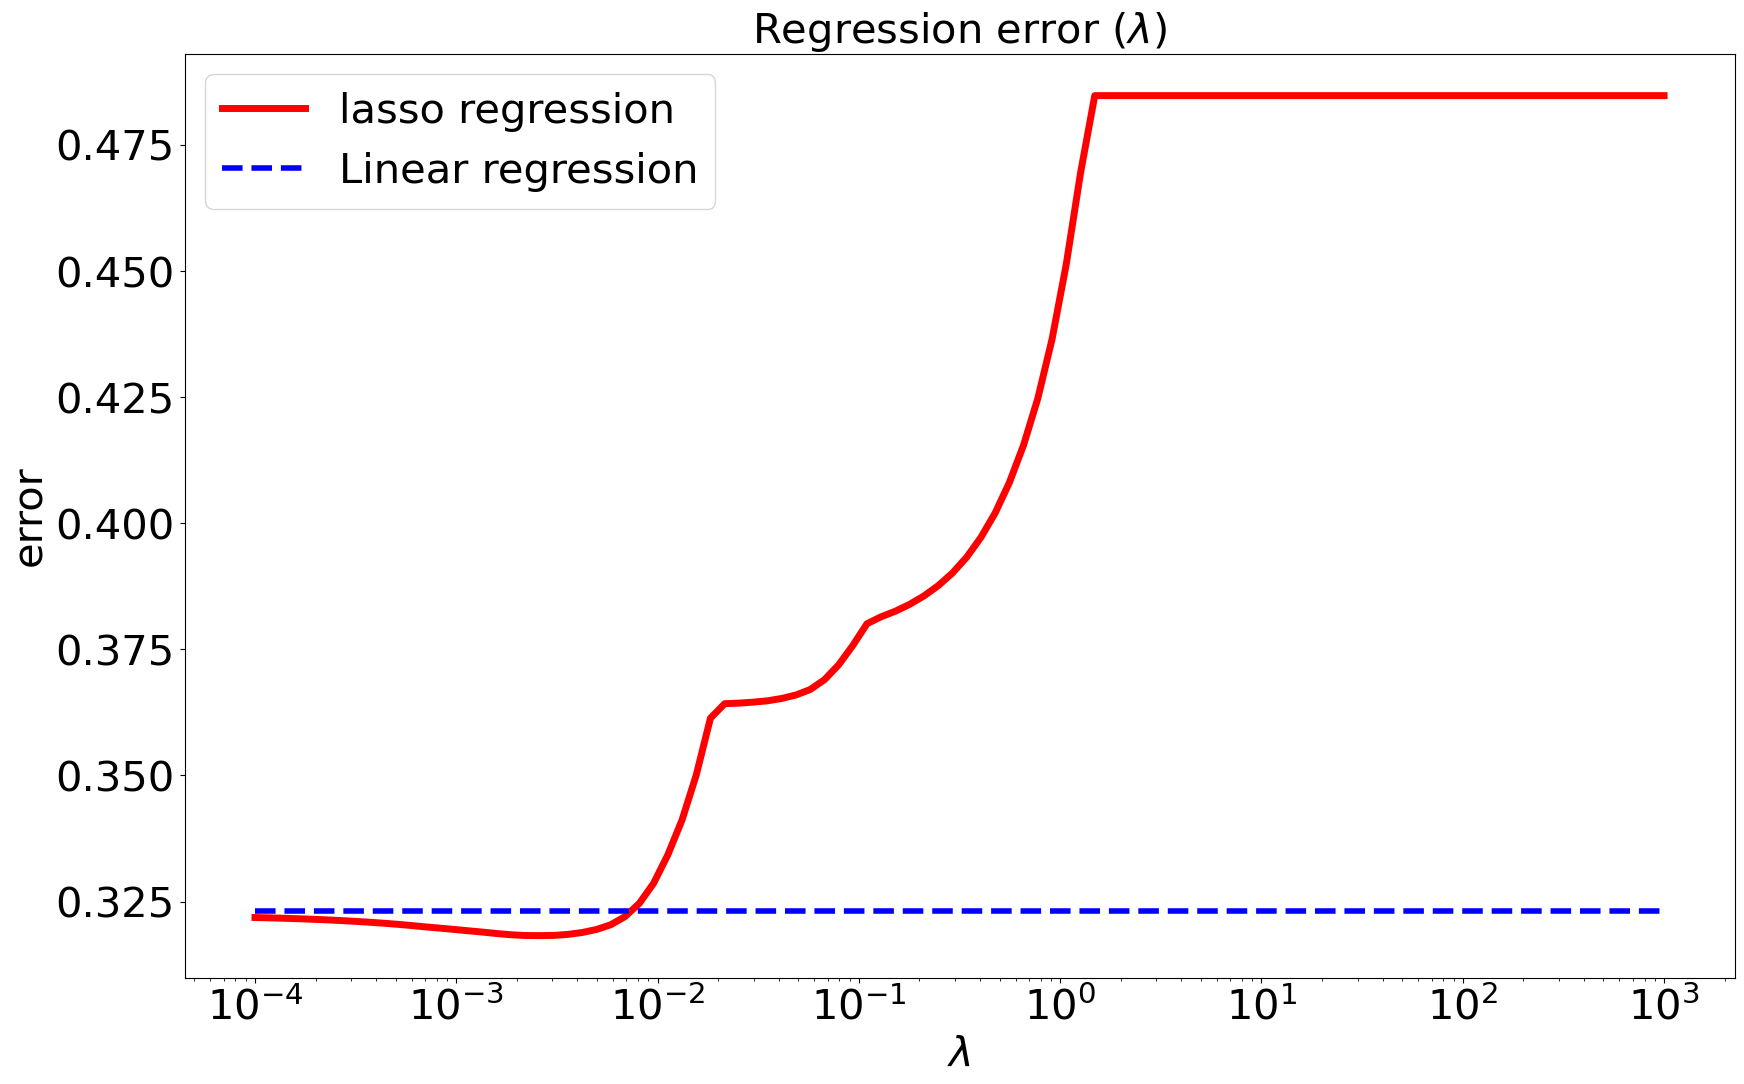

In [183]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="lasso regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
#plt.ylim(200, 400)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

### Ridge

In [185]:
n_alphas = 100
alphas = np.logspace(-4, 3, n_alphas) 

coef_ridge = []
err_ridge = []
baseline = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, Y_train)
    
    coef_ridge.append(ridge.coef_)
    
    y_pred = ridge.predict(X_test)
    ridge_error = mean_absolute_error(y_pred, Y_test)
    
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

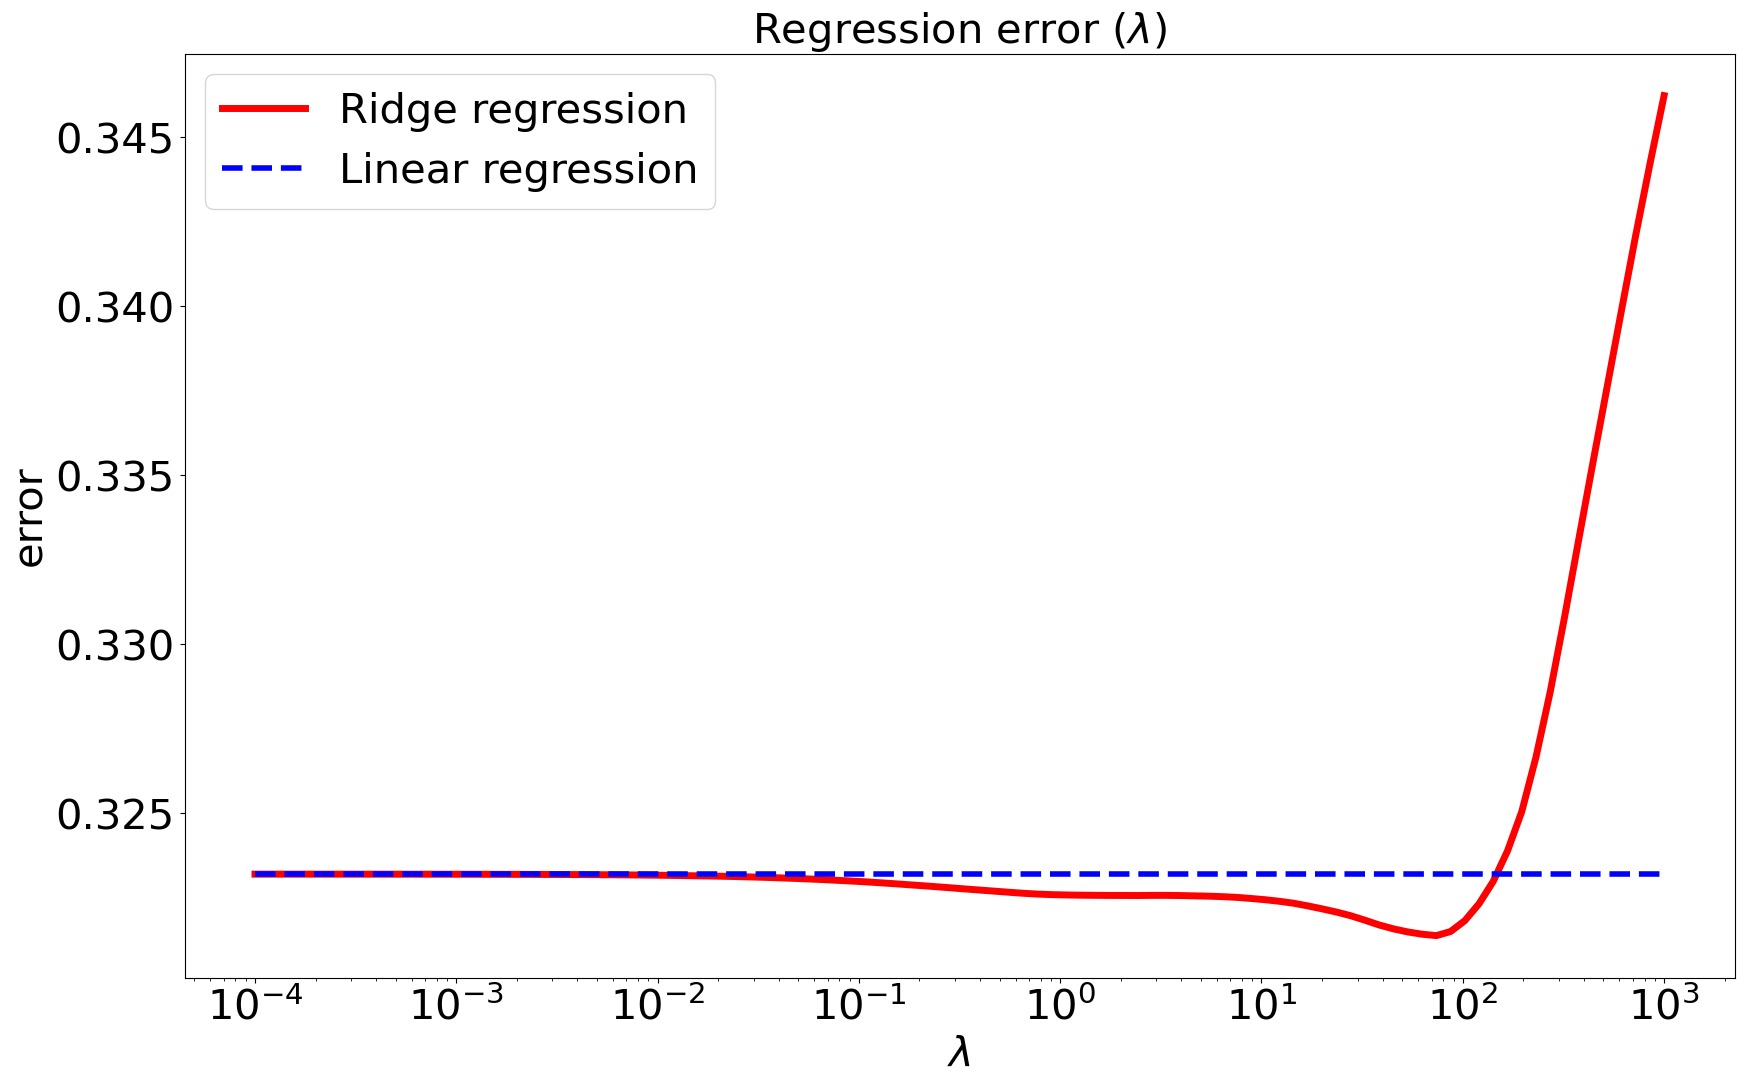

In [186]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
# plt.ylim(380, 400)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

### XGBoost Regressor

In [188]:
# Pruebo XGBoost

xgboost = XGBRegressor()

#Parametros a probar en el gridsearch
parameters = {
    'n_estimators': [20, 25, 30, 35, 40, 45, 50],
    'max_depth': [1, 2, 3],
    'learning_rate': [0.01, 0.1, 0.2]
}


#Estimador a probar en el gridsearch
# svc = svm.SVC()

#Creamos el gridsearch
clf = GridSearchCV(estimator = xgboost,
                  param_grid = parameters,
                  n_jobs = 6,
                  cv = 5,
                  scoring= 'neg_mean_absolute_error')

#Entrenamos el gridsearch
clf.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=6,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [1, 2, 3],
                         'n_estimators': [20, 25, 30, 35, 40, 45, 50]},
             scoring='neg_mean_absolute_error')

In [189]:
clf.best_params_

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}

In [190]:
# XGBoost con mejores parámetros

xgboost = XGBRegressor(n_estimators= 50, max_depth= 3, learning_rate= 0.2)

In [191]:
xgboost.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [192]:
# MAE en train

mean_absolute_error(Y_train, xgboost.predict(X_train))

0.18155190243746203

In [193]:
# MAE en test

mean_absolute_error(Y_test, xgboost.predict(X_test))

0.22077794189735775

In [194]:
# El resultado de XGBoost en test es el mejor, y el overfitting es aceptable
# Considerando ésto, es el modelo que escojo

### ARIMA

In [195]:
from pmdarima.arima import auto_arima, ARIMA

In [196]:
df2.head()

,€/dia,t_ext-24,t_ext-23,t_ext-22,t_ext-21,t_ext-20,t_ext-19,t_ext-18,t_ext-17,t_ext-16,...,€/kWh-10,€/kWh-9,€/kWh-8,€/kWh-7,€/kWh-6,€/kWh-5,€/kWh-4,€/kWh-3,€/kWh-2,€/kWh-1
0,0.025415,16.3,15.6,15.0,14.8,15.9,16.5,16.9,16.3,18.2,...,0.22586,0.24425,0.24498,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566
1,0.000000,15.6,15.0,14.8,15.9,16.5,16.9,16.3,18.2,18.4,...,0.24425,0.24498,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872
2,0.000000,15.0,14.8,15.9,16.5,16.9,16.3,18.2,18.4,19.2,...,0.24498,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872,0.19380
3,0.000000,14.8,15.9,16.5,16.9,16.3,18.2,18.4,19.2,19.9,...,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872,0.19380,0.16898
4,0.000000,15.9,16.5,16.9,16.3,18.2,18.4,19.2,19.9,20.2,...,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872,0.19380,0.16898,0.16923


In [222]:
train = df2['€/dia'][:-720]
test = df2['€/dia'][-720:]

In [223]:
model = auto_arima(train,
                   #stock_df['Open'][:1240].values.reshape(-1,1),
                   start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    stationary=False,
                    trace=True,
                    stepwise=True)

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6462.706, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6466.706, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6464.706, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6464.706, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6468.690, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.364 seconds
-6468.6899487329665


In [224]:
arima_good = ARIMA(order=(0,1,0))
model.fit(train)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2903
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3235.345
Date:                Sun, 26 Nov 2023   AIC                          -6468.690
Time:                        17:55:21   BIC                          -6462.717
Sample:                             0   HQIC                         -6466.538
                               - 2903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0063   2.34e-05    268.572      0.000       0.006       0.006
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1147293.88
Prob(Q):                              1.00   Pr

In [227]:
predictions = model.predict(720)
print("mean_absolute_error:", mean_absolute_error(test, predictions))

mean_absolute_error: 0.4366994684635275


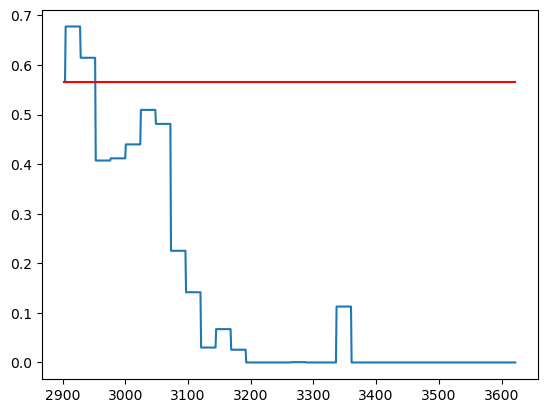

In [226]:
plt.plot(test)
plt.plot(predictions,color='red');

In [228]:
# En mi opinión, a la vista de la serie temporal (estocástica), ARIMA no es un modelo adecuado
# No tiene en cuenta los factores relevantes: temperaturas, precios
# Por tanto, lo descarto

In [203]:
X_test.head()

,t_ext-24,t_ext-23,t_ext-22,t_ext-21,t_ext-20,t_ext-19,t_ext-18,t_ext-17,t_ext-16,t_ext-15,...,€/kWh-10,€/kWh-9,€/kWh-8,€/kWh-7,€/kWh-6,€/kWh-5,€/kWh-4,€/kWh-3,€/kWh-2,€/kWh-1
1869,8.7,9.1,9.5,12.3,9.60,9.1,11.9,12.1,10.70,9.4,...,0.09714,0.09584,0.09653,0.05086,0.05094,0.05442,0.05347,0.09723,0.10660,0.11275
3312,12.7,16.1,15.2,15.1,14.90,14.7,14.5,13.0,13.45,15.2,...,0.12388,0.10782,0.11657,0.14028,0.15788,0.17189,0.19097,0.17801,0.17509,0.16209
1247,14.2,12.5,12.1,11.5,10.40,12.4,12.3,13.6,16.00,16.4,...,0.14975,0.10157,0.10357,0.12105,0.12134,0.18311,0.18617,0.18685,0.18467,0.12349
2593,6.2,5.8,4.9,4.6,4.20,3.5,3.8,3.3,4.20,7.5,...,0.18705,0.19826,0.21753,0.27290,0.28410,0.27514,0.26798,0.21351,0.18971,0.16245
2542,13.2,13.0,12.5,11.1,9.95,8.8,11.0,9.0,9.50,9.1,...,0.23968,0.23627,0.18979,0.19377,0.20484,0.21203,0.26909,0.28644,0.28827,0.27578


In [204]:
df3.drop(columns= ['dia'], inplace= True)

In [205]:
df3.head()

,€/dia,t_ext-24,t_ext-23,t_ext-22,t_ext-21,t_ext-20,t_ext-19,t_ext-18,t_ext-17,t_ext-16,...,€/kWh-10,€/kWh-9,€/kWh-8,€/kWh-7,€/kWh-6,€/kWh-5,€/kWh-4,€/kWh-3,€/kWh-2,€/kWh-1
0,0.000000,15.6,15.0,14.8,15.90,16.5,16.9,16.3,18.2,18.40,...,0.24425,0.24498,0.31560,0.30708,0.30744,0.35719,0.37758,0.30198,0.28566,0.20872
1,0.000000,15.0,14.8,14.6,14.20,14.1,13.8,13.3,13.0,14.10,...,0.14096,0.15892,0.19475,0.20905,0.20918,0.25116,0.25381,0.21370,0.19894,0.16728
2,0.000000,11.0,10.8,10.6,10.80,10.3,9.9,9.7,9.6,10.25,...,0.18224,0.20612,0.25624,0.31795,0.31450,0.32499,0.27735,0.20276,0.18787,0.16115
3,0.000000,14.0,13.9,18.0,20.70,17.9,18.7,20.4,20.6,20.10,...,0.19815,0.20692,0.21203,0.29282,0.27084,0.25057,0.24510,0.19544,0.18077,0.20838
4,0.105214,13.1,13.6,14.1,14.25,14.4,13.7,14.0,13.1,14.30,...,0.17341,0.20984,0.23515,0.30798,0.35728,0.33038,0.32079,0.26236,0.24619,0.19349


In [206]:
# Estos son días naturales, no cualquier período de 24 horas

X_days = df3.drop(columns= ['€/dia'])
Y_days = df3['€/dia']

In [208]:
# MAE en días naturales con el mejor XGboost

mean_absolute_error(Y_days, xgboost.predict(X_days))

0.19732353164100463

In [ ]:
# El MAE se mantiene estable, refuerza la idea de que XGboost es un modelo adecuado en esta situación

''

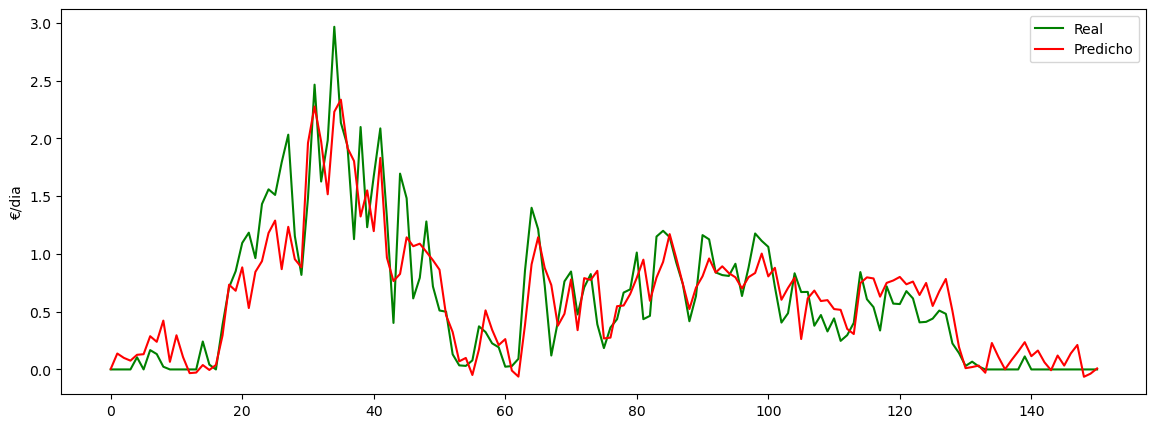

In [209]:
plt.figure(figsize= (14, 5))
sns.lineplot(Y_days, color= 'g', label= 'Real')
sns.lineplot(xgboost.predict(X_days), color= 'r', label= 'Predicho')
;

## Predicciones de coste con distintas estrategias

In [210]:
dias_caros = df3.copy()

In [211]:
dias_caros.loc[:,'t_int-7':'t_int-1'] = 21

In [212]:
estrategia_1 = xgboost.predict(dias_caros.drop(columns= '€/dia'))

In [213]:
dias_caros.loc[:,'t_int-9':'t_int-7'] = 23

In [214]:
dias_caros.loc[:, 't_int-7':'t_int-1'] = 19

In [215]:
estrategia_2 = xgboost.predict(dias_caros.drop(columns= '€/dia'))

''

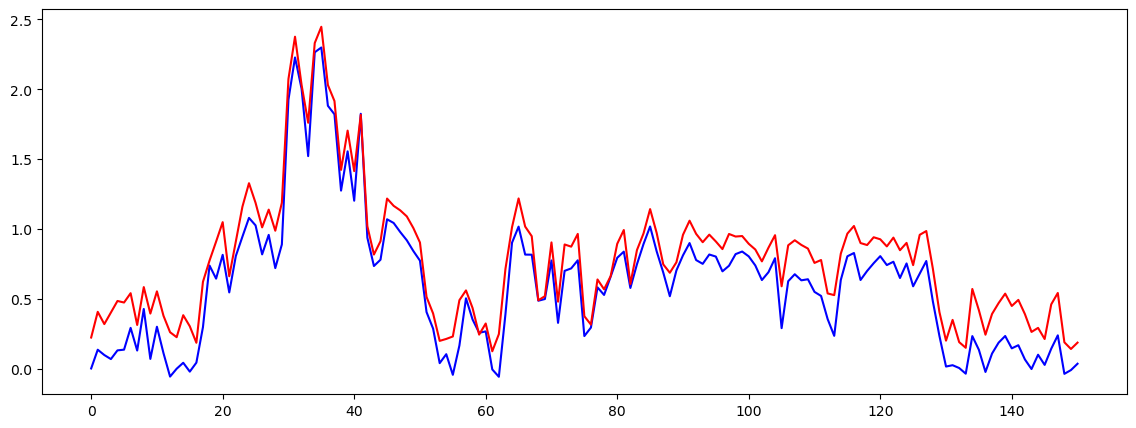

In [216]:
plt.figure(figsize= (14, 5))
sns.lineplot(estrategia_1, color= 'b')
sns.lineplot(estrategia_2, color= 'r')
;

In [217]:
euros = estrategia_1 - estrategia_2

''

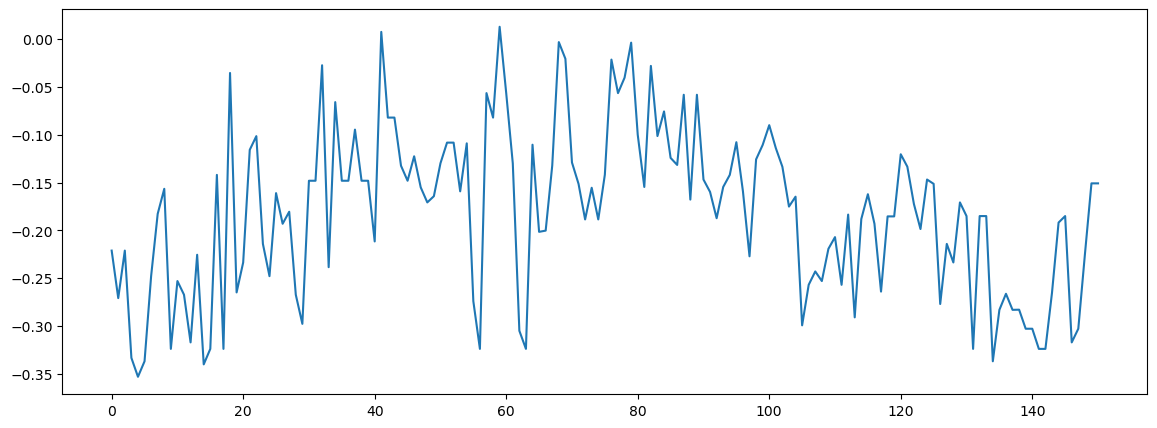

In [218]:
plt.figure(figsize= (14, 5))
sns.lineplot(euros)
;

In [219]:
estrategia_1.sum()

91.44858

In [220]:
estrategia_2.sum()

118.86423

In [221]:
dias_caros['€/dia'].sum()

94.25442384326578